# Testing New Experiment API

Load data.

In [1]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore') 

import rdkit
import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Load assays and utility functions.

In [2]:
import os

def get_tcp_objectives():

    dockstring_dir = f'{path}/dockstring_targets/'
    files = os.listdir(dockstring_dir)
    configs = sorted([f for f in files if 'conf' in f])
    targets = sorted([f for f in files if 'target' in f])

    idx = 0
    with open(dockstring_dir + configs[idx], 'r') as f:
        config_ = f.readlines()
        config_ = [c.replace('\n', '') for c in config_]
        config_ = [c.split(' = ') for c in config_ if c]
        config_ = {c[0]: float(c[1]) for c in config_}

    target = targets[idx]
    name = target.split('_')[0]

    config_.update({
        'size_x': 22.5,
        'size_y': 22.5,
        'size_z': 22.5,
    })

    from dgym.envs.oracle import \
        DockingOracle, CatBoostOracle, RDKitOracle, NoisyOracle
    from dgym.envs.utility import ClassicUtilityFunction

    config = {
        'search_mode': 'detailed',
        'scoring': 'vina',
        'seed': 5,
        **config_
    }

    pIC50_oracle = DockingOracle(
        f'{name} pIC50',
        receptor_path=f'{path}/dockstring_targets/{name}_target.pdbqt',
        config=config
    )
    qed_oracle = RDKitOracle('QED', descriptor='QED')
    log_P_oracle = RDKitOracle('Log P', descriptor='MolLogP')
    log_S_oracle = CatBoostOracle(
        'Log S', path='../dgym/envs/models/aqsolcb.model')
    
    return pIC50_oracle, qed_oracle, log_P_oracle, log_S_oracle

In [3]:
from dgym.envs.utility import ClassicUtilityFunction, MultipleUtilityFunction

# Get objectives
pIC50_oracle, qed_oracle, log_P_oracle, log_S_oracle = get_tcp_objectives()

# Define utility functions
pIC50_utility = ClassicUtilityFunction(
    pIC50_oracle, ideal=(9.5, 13), acceptable=(8, 13))
log_P_utility = ClassicUtilityFunction(
    log_P_oracle, ideal=(0.5, 1.85), acceptable=(-0.5, 3.5))
log_S_utility = ClassicUtilityFunction(
    log_S_oracle, ideal=(-3, 1), acceptable=(-4, 1))
# qed_utility = ClassicUtilityFunction(
#     qed_oracle, ideal=(0.65, 1.0), acceptable=(0.5, 1.0))

# Assemble assays and surrogate models
assays = [
    pIC50_oracle,
    log_P_oracle,
    log_S_oracle,
    # qed_oracle,
    pIC50_oracle.surrogate(sigma=1.0),
    log_P_oracle.surrogate(sigma=1.0),
    log_S_oracle.surrogate(sigma=1.0),
    # qed_oracle.surrogate(sigma=0.1),
]

# Environment tolerates acceptable ADMET
from copy import deepcopy
utility_agent = MultipleUtilityFunction(
    utility_functions = [pIC50_utility, log_P_utility, log_S_utility],
    weights = [0.8, 0.1, 0.1]
)
utility_env = deepcopy(utility_agent)
utility_env.utility_functions[1].ideal = utility_env.utility_functions[1].acceptable
utility_env.utility_functions[2].ideal = utility_env.utility_functions[2].acceptable

Instantiate designer.

In [4]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Pick 5 random starting hits.

In [5]:
# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
library = dg.MoleculeCollection(initial_molecules).update_annotations()

# Score molecules
for assay in assays:
    if 'Noisy' not in assay.name:
        results = assay(library)
        for molecule, result in zip(library, results):
            molecule.update_annotations({assay.name: result})

# Set status to tested
library.set_status('Tested', step=0)

Instantiate Environment and Agent.

In [9]:
from dgym.envs import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy

drug_env = DrugEnv(
    designer = designer,
    library = library,
    assays = assays,
    utility_function = utility_env
)

# Construct sequence
design_grow = {'name': 'design', 'batch_size': 24, 'parameters': {'strategy': 'grow', 'size': 5}}
design_replace = {'name': 'design', 'batch_size': 24, 'parameters': {'strategy': 'replace', 'size': 5, 'temperature': 0.2}}
score = {'name': ['Noisy ABL1 pIC50', 'Noisy Log S', 'Noisy Log P'], 'batch_size': 24 * 5, 'parameters': {'batch_size': 40}}
make = {'name': 'make', 'batch_size': 24}
test = {'name': ['ABL1 pIC50', 'Log S', 'Log P'], 'batch_size': 24}
design_and_score = [design_replace, score]

sequence = [*(design_and_score * 1), design_grow, score, make, test]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    exploration_strategy = EpsilonGreedy(epsilon=0.25),
    utility_function = utility_agent
)

In [10]:
def display_best(experiment):
    import numpy as np
    observations = experiment.drug_env.library
    utilities = experiment.drug_env.utility_function(
        observations, use_precomputed=True, method='average')
    for obs, utility in zip(observations, utilities):
        obs.update_annotations({'utility': utility})
    tested = observations.tested
    if tested:
        best_tested = (
            tested
            .annotations
            .sort_values('utility', ascending=False)
            [['ABL1 pIC50', 'Log S', 'Log P', 'utility']]
            .head()
        )
        display(best_tested)

In [11]:
from dgym.experiment import Experiment

experiment = Experiment(
    drug_env=drug_env,
    drug_agent=drug_agent
)

result = experiment.run()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Created action
{'name': 'design', 'parameters': {'strategy': 'replace', 'size': 5, 'temperature': 0.2}, 'molecules': [2, 3, 4, 1, 0]}
-4.195363380608727
Created action
{'name': ['Noisy ABL1 pIC50', 'Noisy Log S', 'Noisy Log P'], 'parameters': {'batch_size': 40}, 'molecules': [5, 28, 6, 7, 8, 9, 14, 16, 10, 11, 12, 13, 19, 21, 15, 17, 23, 18, 27, 22, 20, 25, 24, 26, 29]}
{'batch_size': 40}
{'batch_size': 40}
{'batch_size': 40}
-4.195363380608727
Created action
{'name': 'design', 'parameters': {'strategy': 'grow', 'size': 5}, 'molecules': [14, 12, 9, 18, 2, 4, 3, 6, 20, 11, 5, 15, 29, 27, 26, 19, 13, 1, 7, 28, 25, 17, 22, 23]}
-4.195363380608727
Created action
{'name': ['Noisy ABL1 pIC50', 'Noisy Log S', 'Noisy Log P'], 'parameters': {'batch_size': 40}, 'molecules': [30, 72, 31, 32, 33, 34, 35, 36, 37, 38, 129, 39, 56, 40, 41, 83, 42, 43, 44, 45, 91, 97, 46, 89, 47, 96, 48, 49, 50, 51, 52, 53, 139, 112, 54, 55, 57, 58, 126, 59, 61, 114, 60, 116, 74, 113, 62, 63, 108, 93, 64, 65, 66, 135,

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x7f8ab76abb00>
Traceback (most recent call last):
  File "/home/mrr/miniconda3/envs/chodera/lib/python3.11/_weakrefset.py", line 39, in _remove
    def _remove(item, selfref=ref(self)):

KeyboardInterrupt: 


KeyboardInterrupt: 

In [20]:
def _batched(iterable, n):
    if n < 1:
        raise ValueError('n must be at least one')
    it = iter(iterable)
    while batch := tuple(itertools.islice(it, n)):
        yield batch

In [9]:
import seaborn as sns
experiment.drug_env.library.tested.annotations.reindex(
    columns=[*drug_env.assays, 'Current Status', 'Step Designed', 'Step Scored', 'Step Made', 'Step Tested'])

,ABL1 pIC50,Log P,Log S,Noisy ABL1 pIC50,Noisy Log P,Noisy Log S,Current Status,Step Designed,Step Scored,Step Made,Step Tested
0,6.076101,0.54540,-1.590588,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
1,6.820261,2.72560,-3.184914,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
2,6.229260,2.06640,-2.940035,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
3,7.337557,2.98100,-3.286121,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
4,6.451403,1.82690,-1.673516,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
4776,9.318329,0.94130,-4.446550,10.203349,-1.422194,-2.704071,Tested,61.0,61.0,62.0,62
4795,7.808678,0.78166,-2.900389,8.437675,1.320300,-2.404896,Tested,61.0,61.0,62.0,62
4807,7.979651,0.41260,-2.818114,9.272024,-0.657224,-2.937937,Tested,61.0,61.0,62.0,62
4846,6.997189,1.84836,-3.540631,9.319872,0.532536,-3.519093,Tested,61.0,61.0,62.0,62


/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and 

<Figure size 1920x1440 with 0 Axes>

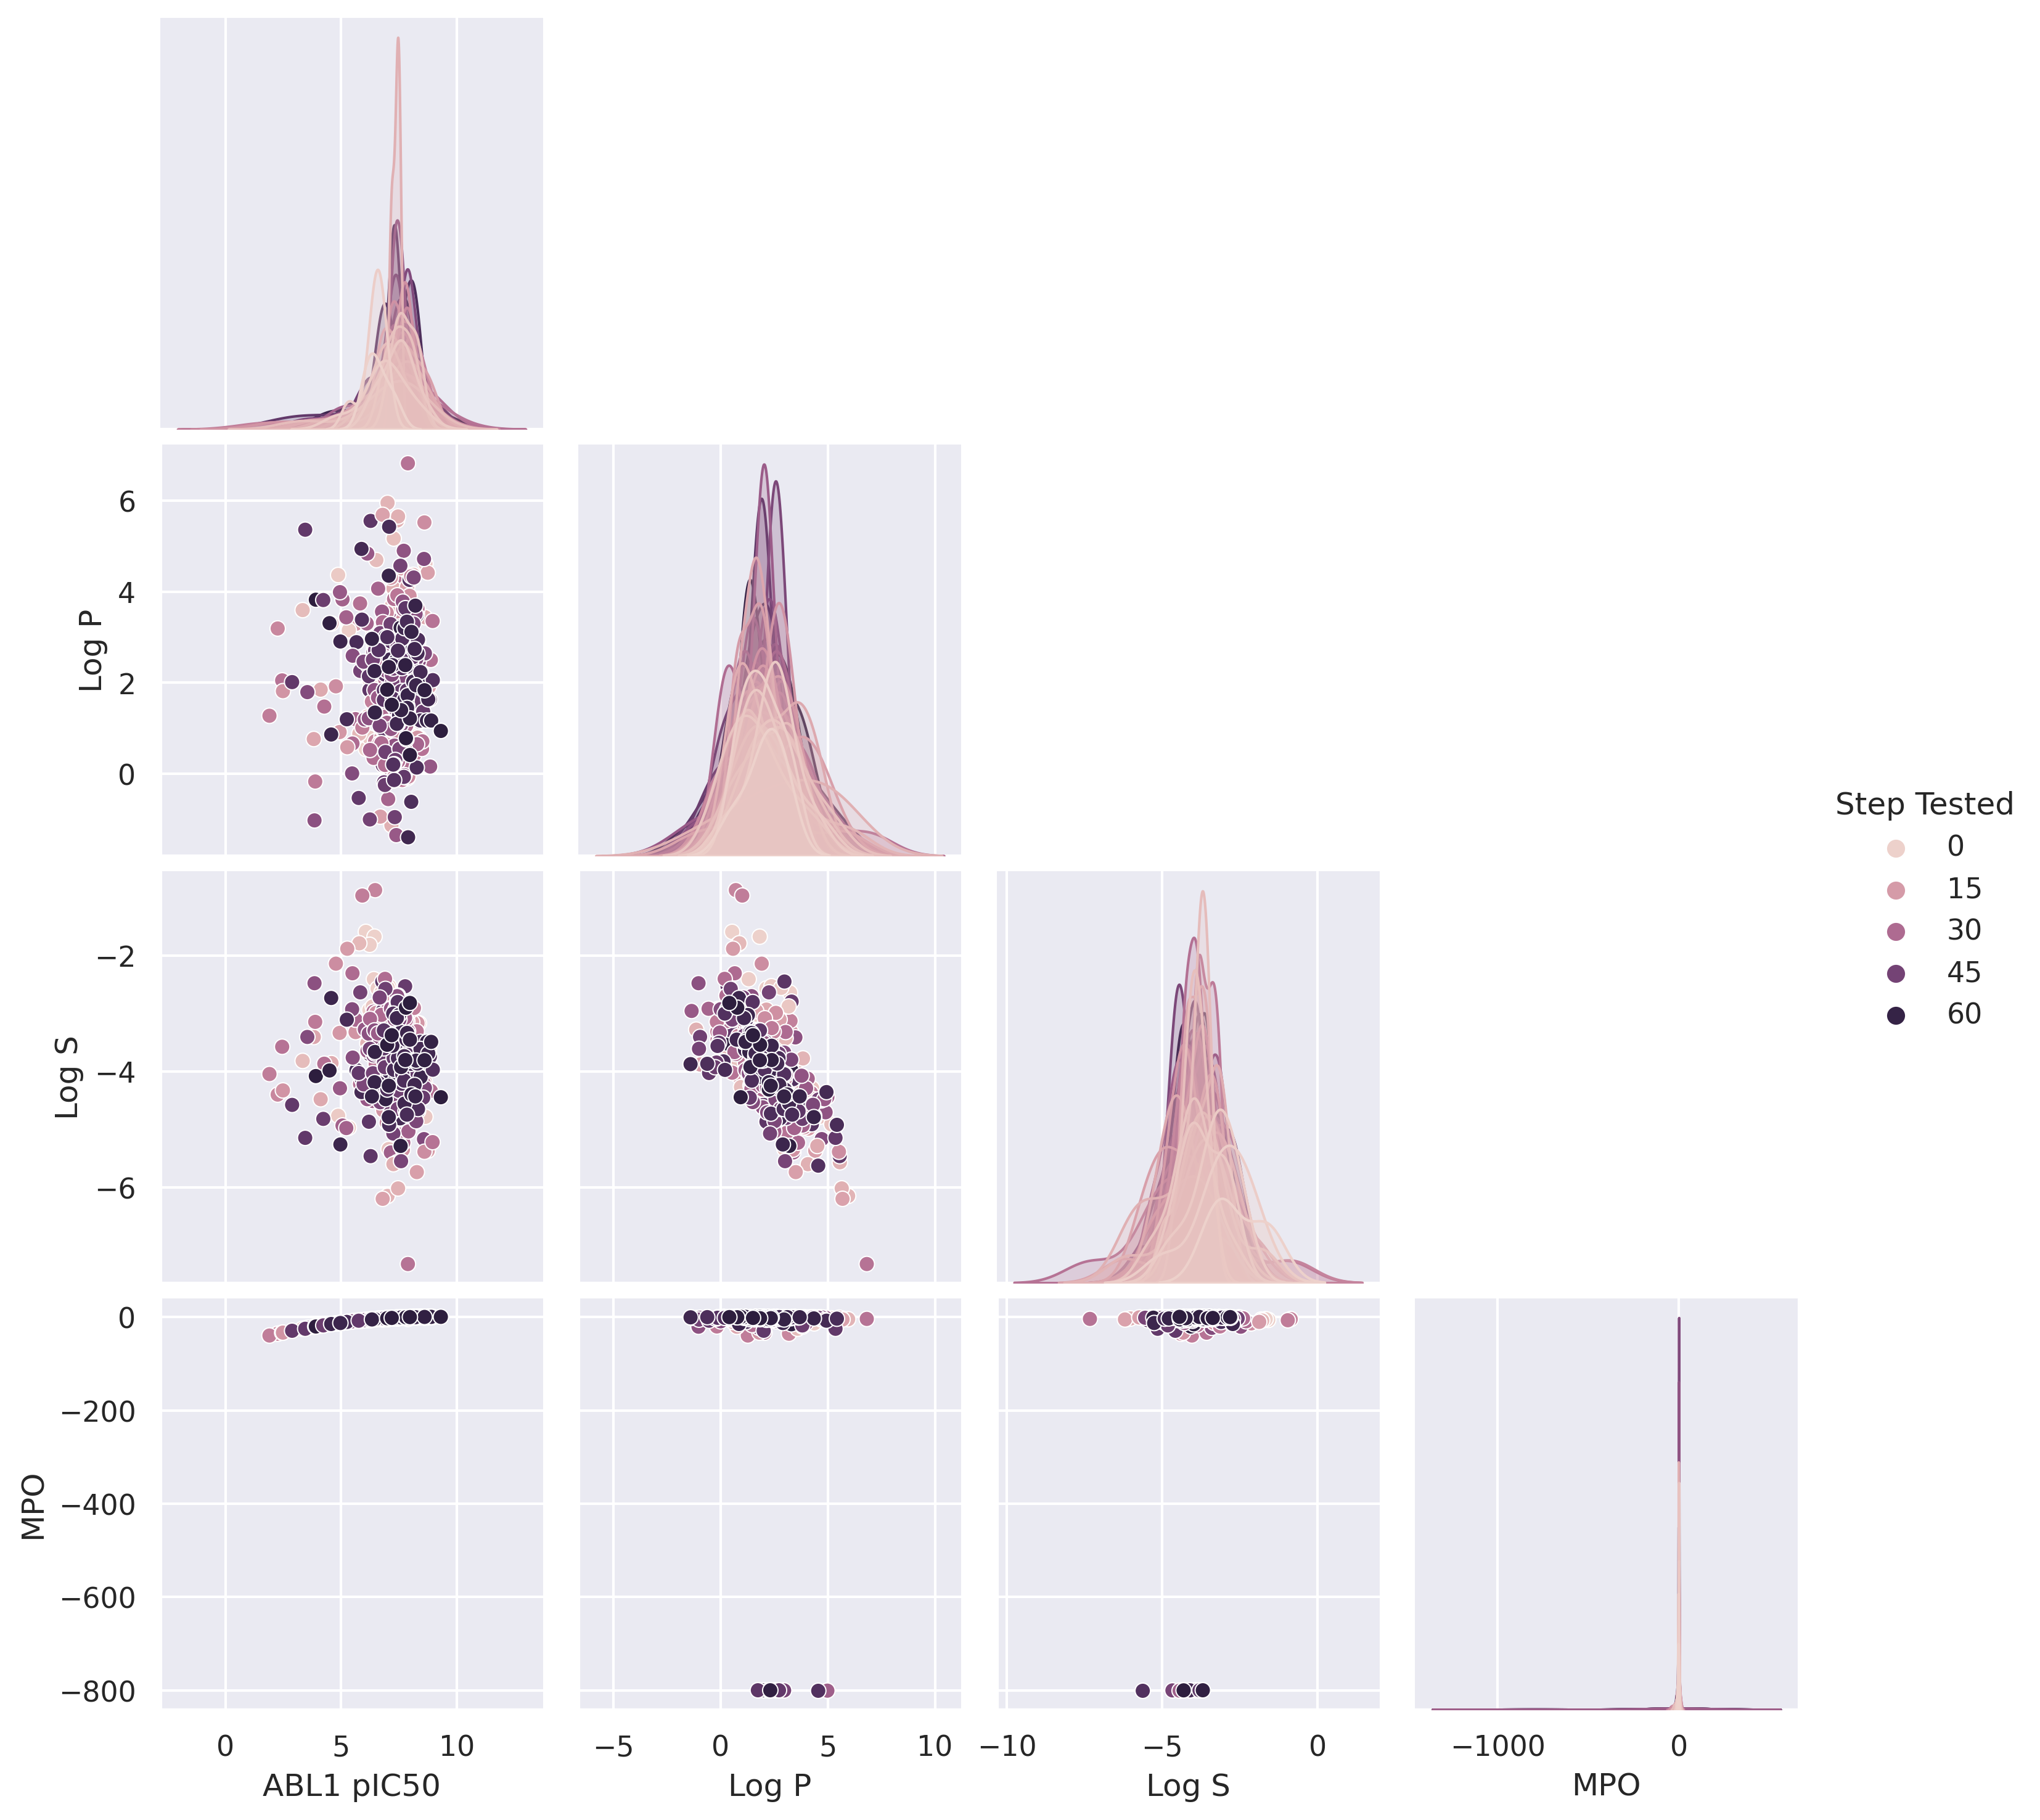

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(dpi=300)

pairplot_df = experiment.drug_env.library.annotations[
    ['ABL1 pIC50', 'Log P', 'Log S', 'Step Tested']
]

pairplot_df['MPO'] = experiment.drug_env.utility_function(drug_env.library, use_precomputed=True, method='average')

sns.set_theme()
g = sns.pairplot(
    pairplot_df,
    corner=True,
    hue='Step Tested'
)
g.fig.set_dpi(300)

In [11]:
max_timestep = int(experiment.drug_env.library.annotations['Step Tested'].max())

objective = 'ABL1 pIC50'
records = []
for timestep, group in pairplot_df.groupby('Step Tested'):
    for _, mol in group.iterrows():
        record = {
            'pIC50': mol[objective], 'Step Tested': timestep}
        records.append(record)
        
        # Duplicate logic for each possible timestep
        for t in range(1, max_timestep + 1):
            if timestep < t:
                records.append({**record, 'Step Tested': int(t)})

df = pd.DataFrame(records)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Distribution of ligand potencies across rounds')

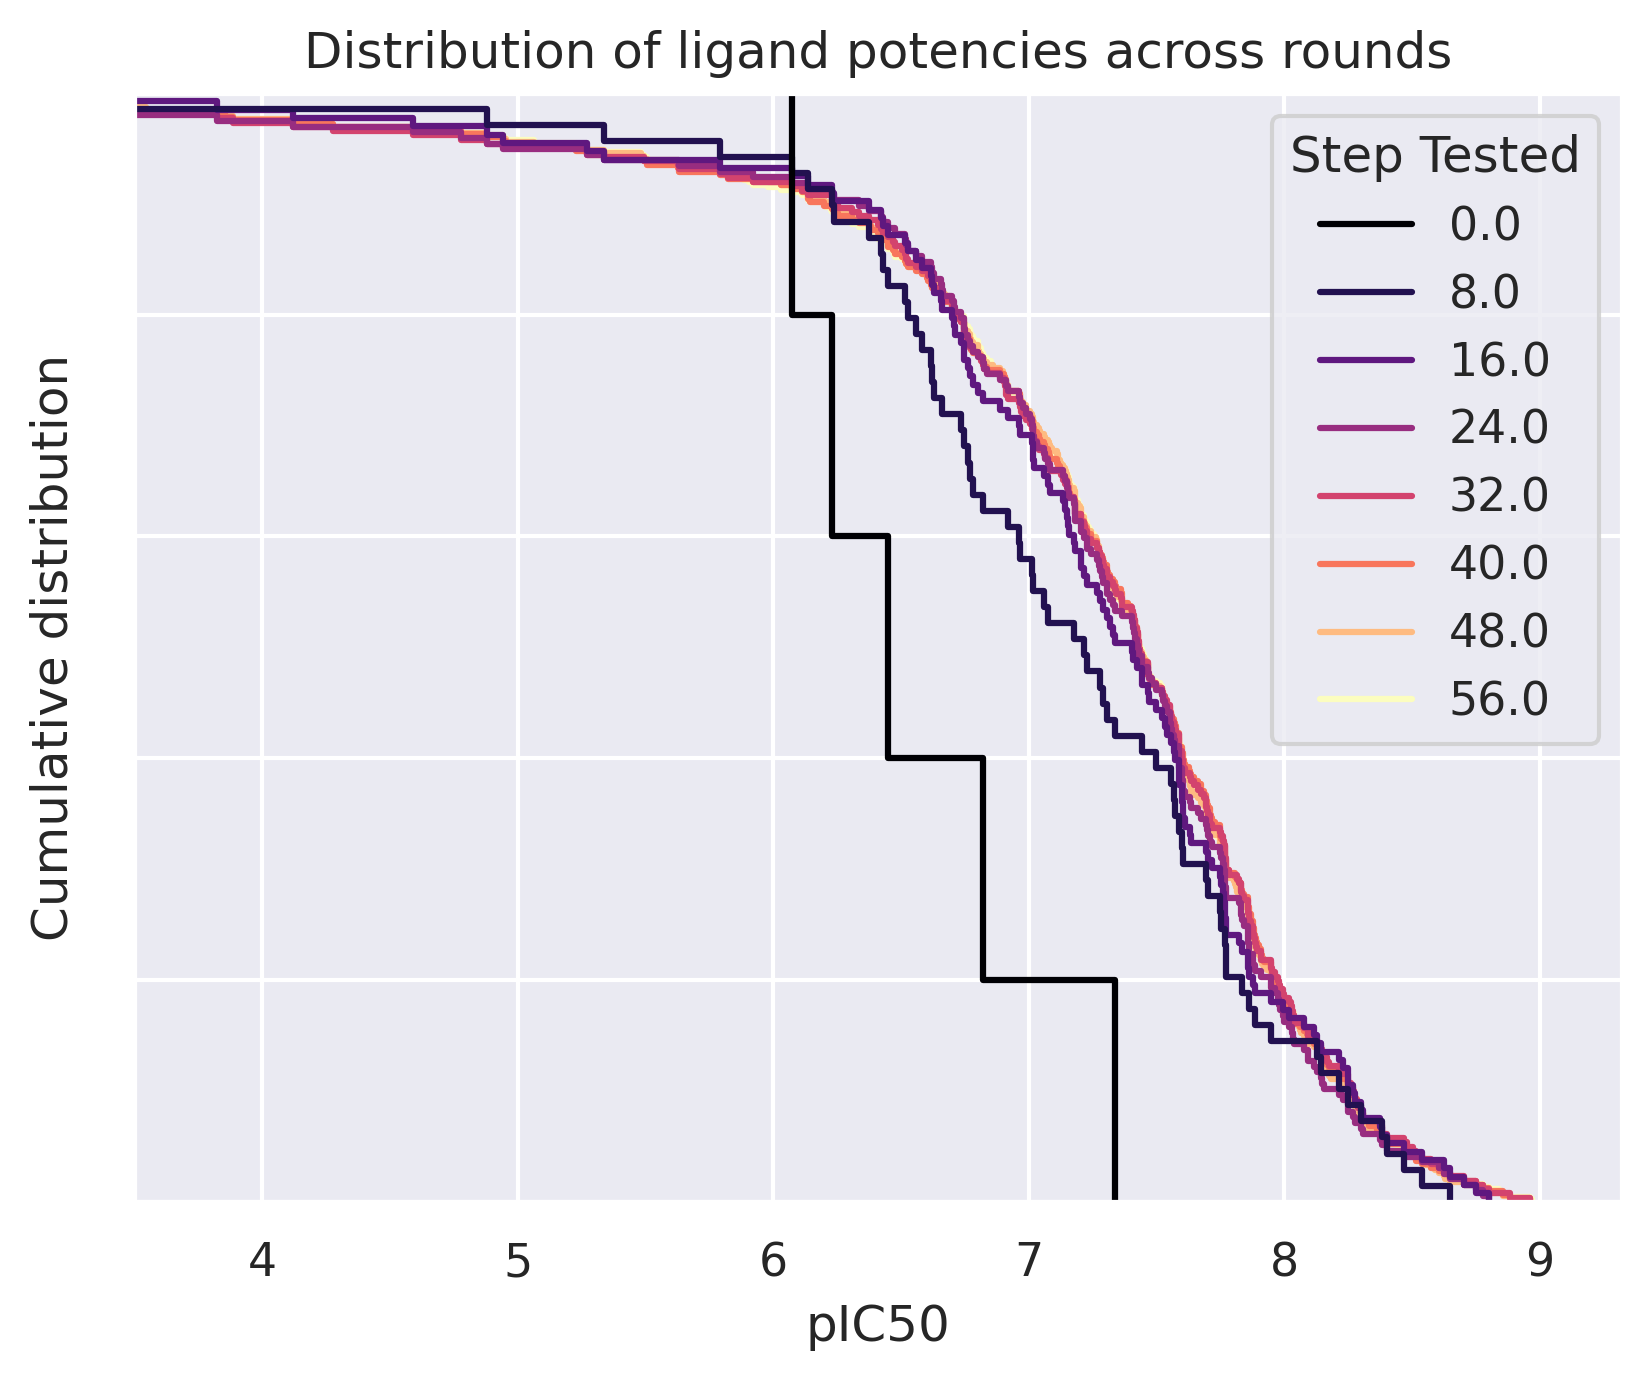

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(dpi=300)

g = sns.ecdfplot(
    df.query('`Step Tested` % 8 == 0'),
    x='pIC50',
    hue='Step Tested',
    palette='magma',
    complementary=True
)

g.set(yticklabels=[])

plt.xlim(3.5)
plt.xlabel('pIC50')
plt.ylabel('Cumulative distribution')
plt.title('Distribution of ligand potencies across rounds')

In [13]:
display_best(experiment)

,ABL1 pIC50,Log S,Log P,utility
4063,8.970502,-3.971282,2.0582,0.717601
4776,9.318329,-4.446550,0.9413,0.693858
4645,8.899949,-3.490776,1.1705,0.679973
2749,8.855087,-3.905043,0.1589,0.656046
3767,8.843037,-3.745542,1.6346,0.649620


In [53]:
display_best(experiment)

,ABL1 pIC50,QED,Log S,Log P,utility
1941,9.349517,0.530259,-3.182481,1.5854,0.981752
3751,9.006238,0.793453,-3.222436,1.9620,0.977756
2558,9.259852,0.714511,-3.392674,2.0289,0.960733
2478,9.810155,0.562042,-3.402468,0.5471,0.959753
2429,9.207359,0.720624,-3.404347,1.8360,0.959565


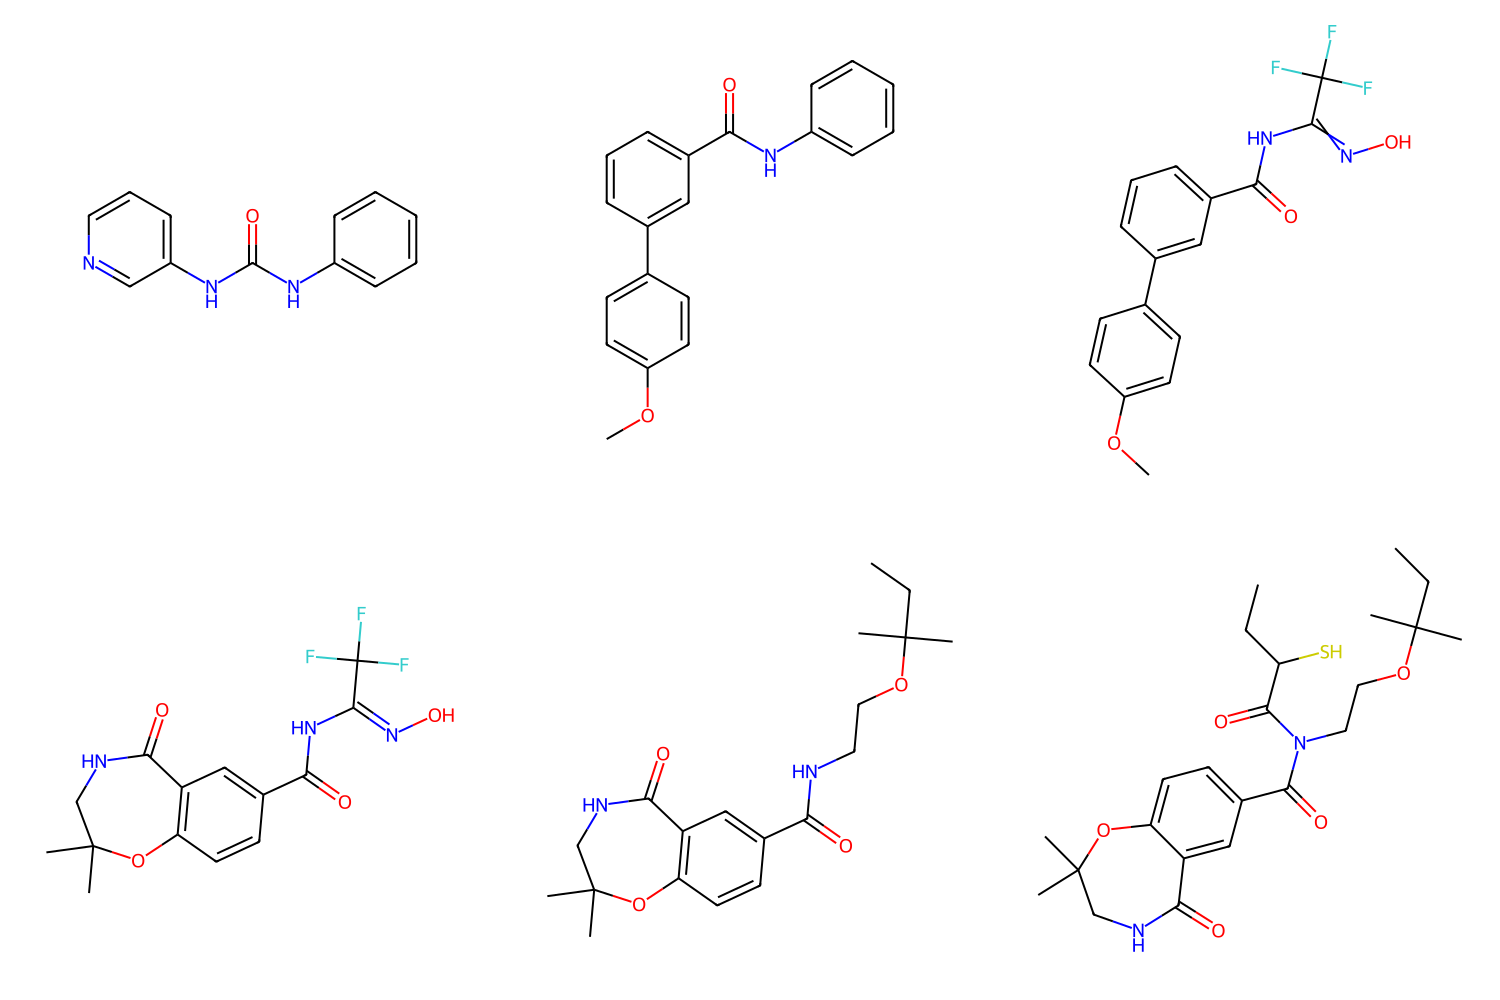

In [14]:
from rdkit.Chem.Draw import MolsToGridImage

molecule = experiment.drug_env.library[1990]
lineage = dg.utils.align_lineage(molecule)

MolsToGridImage([m.mol for m in lineage], subImgSize=(500, 500))

# Visualize trajectory

In [15]:
import seaborn as sns

palette = sns.color_palette("magma", as_cmap=True)

def normalize_array(arr):
    """
    Normalize a numpy array to have its minimum and maximum values scaled to 0 and 1, respectively.
    
    Parameters
    ----------
    arr : np.ndarray
        The input array to normalize.
    
    Returns
    -------
    np.ndarray
        The normalized array with values scaled between 0 and 1.
    
    Example
    -------
    >>> arr = np.array([10, 20, 30, 40, 50])
    >>> normalize_array(arr)
    array([0. , 0.25, 0.5 , 0.75, 1. ])
    """
    arr = np.array(arr)
    min_val = np.nanmin(arr)
    max_val = np.nanmax(arr)
    normalized_arr = (arr - min_val) / (max_val - min_val)
    return normalized_arr

In [20]:
import math
import numpy as np
import igraph as ig

graph_scores = []
adjacency_tuples = []
for molecule in experiment.drug_env.library.tested[::4]:
    lineage = molecule.lineage
    for idx in range(len(lineage) - 1):
        adjacency_tuple = (lineage[idx].name, lineage[idx+1].name)
        adjacency_tuples.append(adjacency_tuple)

g = ig.Graph.TupleList(set(adjacency_tuples), directed=True)

# Remove self-loops
g = g.simplify()

# # Get the in-degree of each vertex
# in_degrees = g.degree(mode='in')

# # Root vertices have an in-degree of 0
# root_vertices = [v.index for v in g.vs if in_degrees[v.index] == 0]

# # Add common ancestor
# roots = g.get_vertex_dataframe()['name'][root_vertices]
# g.add_vertex('parent')
# g.add_edges([
#     ('parent', root_name) for root_name in roots
# ])

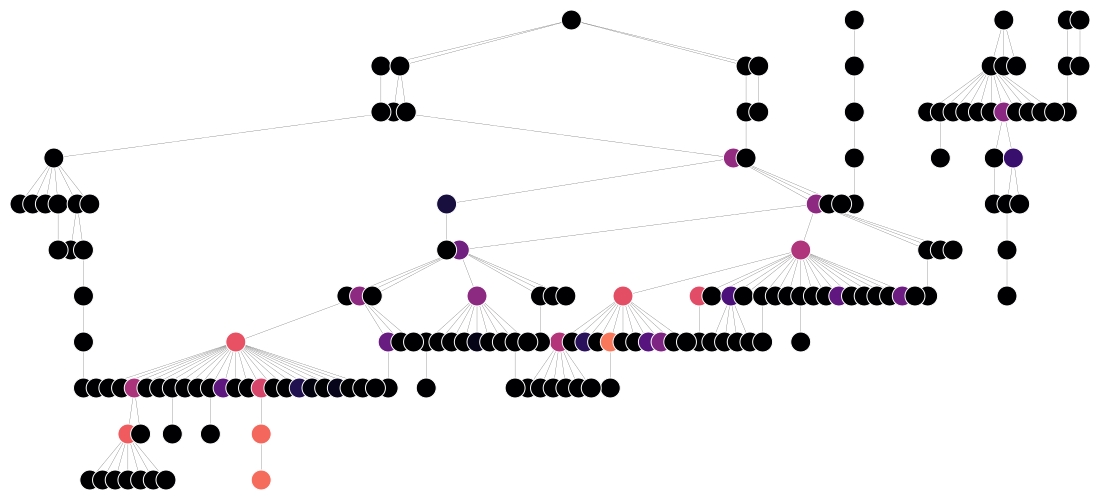

In [21]:
scores = [
    experiment.drug_env.utility_function(
        experiment.drug_env.library[v], use_precomputed=True, method='average')
    for v in g.get_vertex_dataframe()['name']
    if v != 'parent'
]

# Step 1: Identify leaves
# A leaf is a vertex with out-degree of 0
out_degrees = g.outdegree()
leaves = [idx for idx, degree in enumerate(out_degrees) if degree == 0]

# Step 2: Customize vertex colors and outlines
vertex_colors = [palette(score) for score in scores]
vertex_frame_colors = ['white'] * len(vertex_colors)
vertex_frame_width = [1.0] * len(vertex_colors)

# # Customize leaves
# for leaf in leaves:
#     vertex_frame_colors[leaf] = vertex_colors[leaf][:3]
#     vertex_colors[leaf] = vertex_colors[leaf][:3] + (0.05,)
#     vertex_frame_width[leaf] = 1.0 # 0.0

# Step 3: Plot the graph
visual_style = {
    "layout": g.layout("rt"),
    "bbox": (1_100, 500),
    "vertex_color": vertex_colors,
    "vertex_frame_color": vertex_frame_colors,
    "vertex_frame_width": vertex_frame_width,
    "edge_width": 0.25,
    "colorbar": palette,
    "edge_arrow_size": 0.0, # 0.3,
    "margin": 20,
    "vertex_size": 20,
}

ig.plot(g, **visual_style)

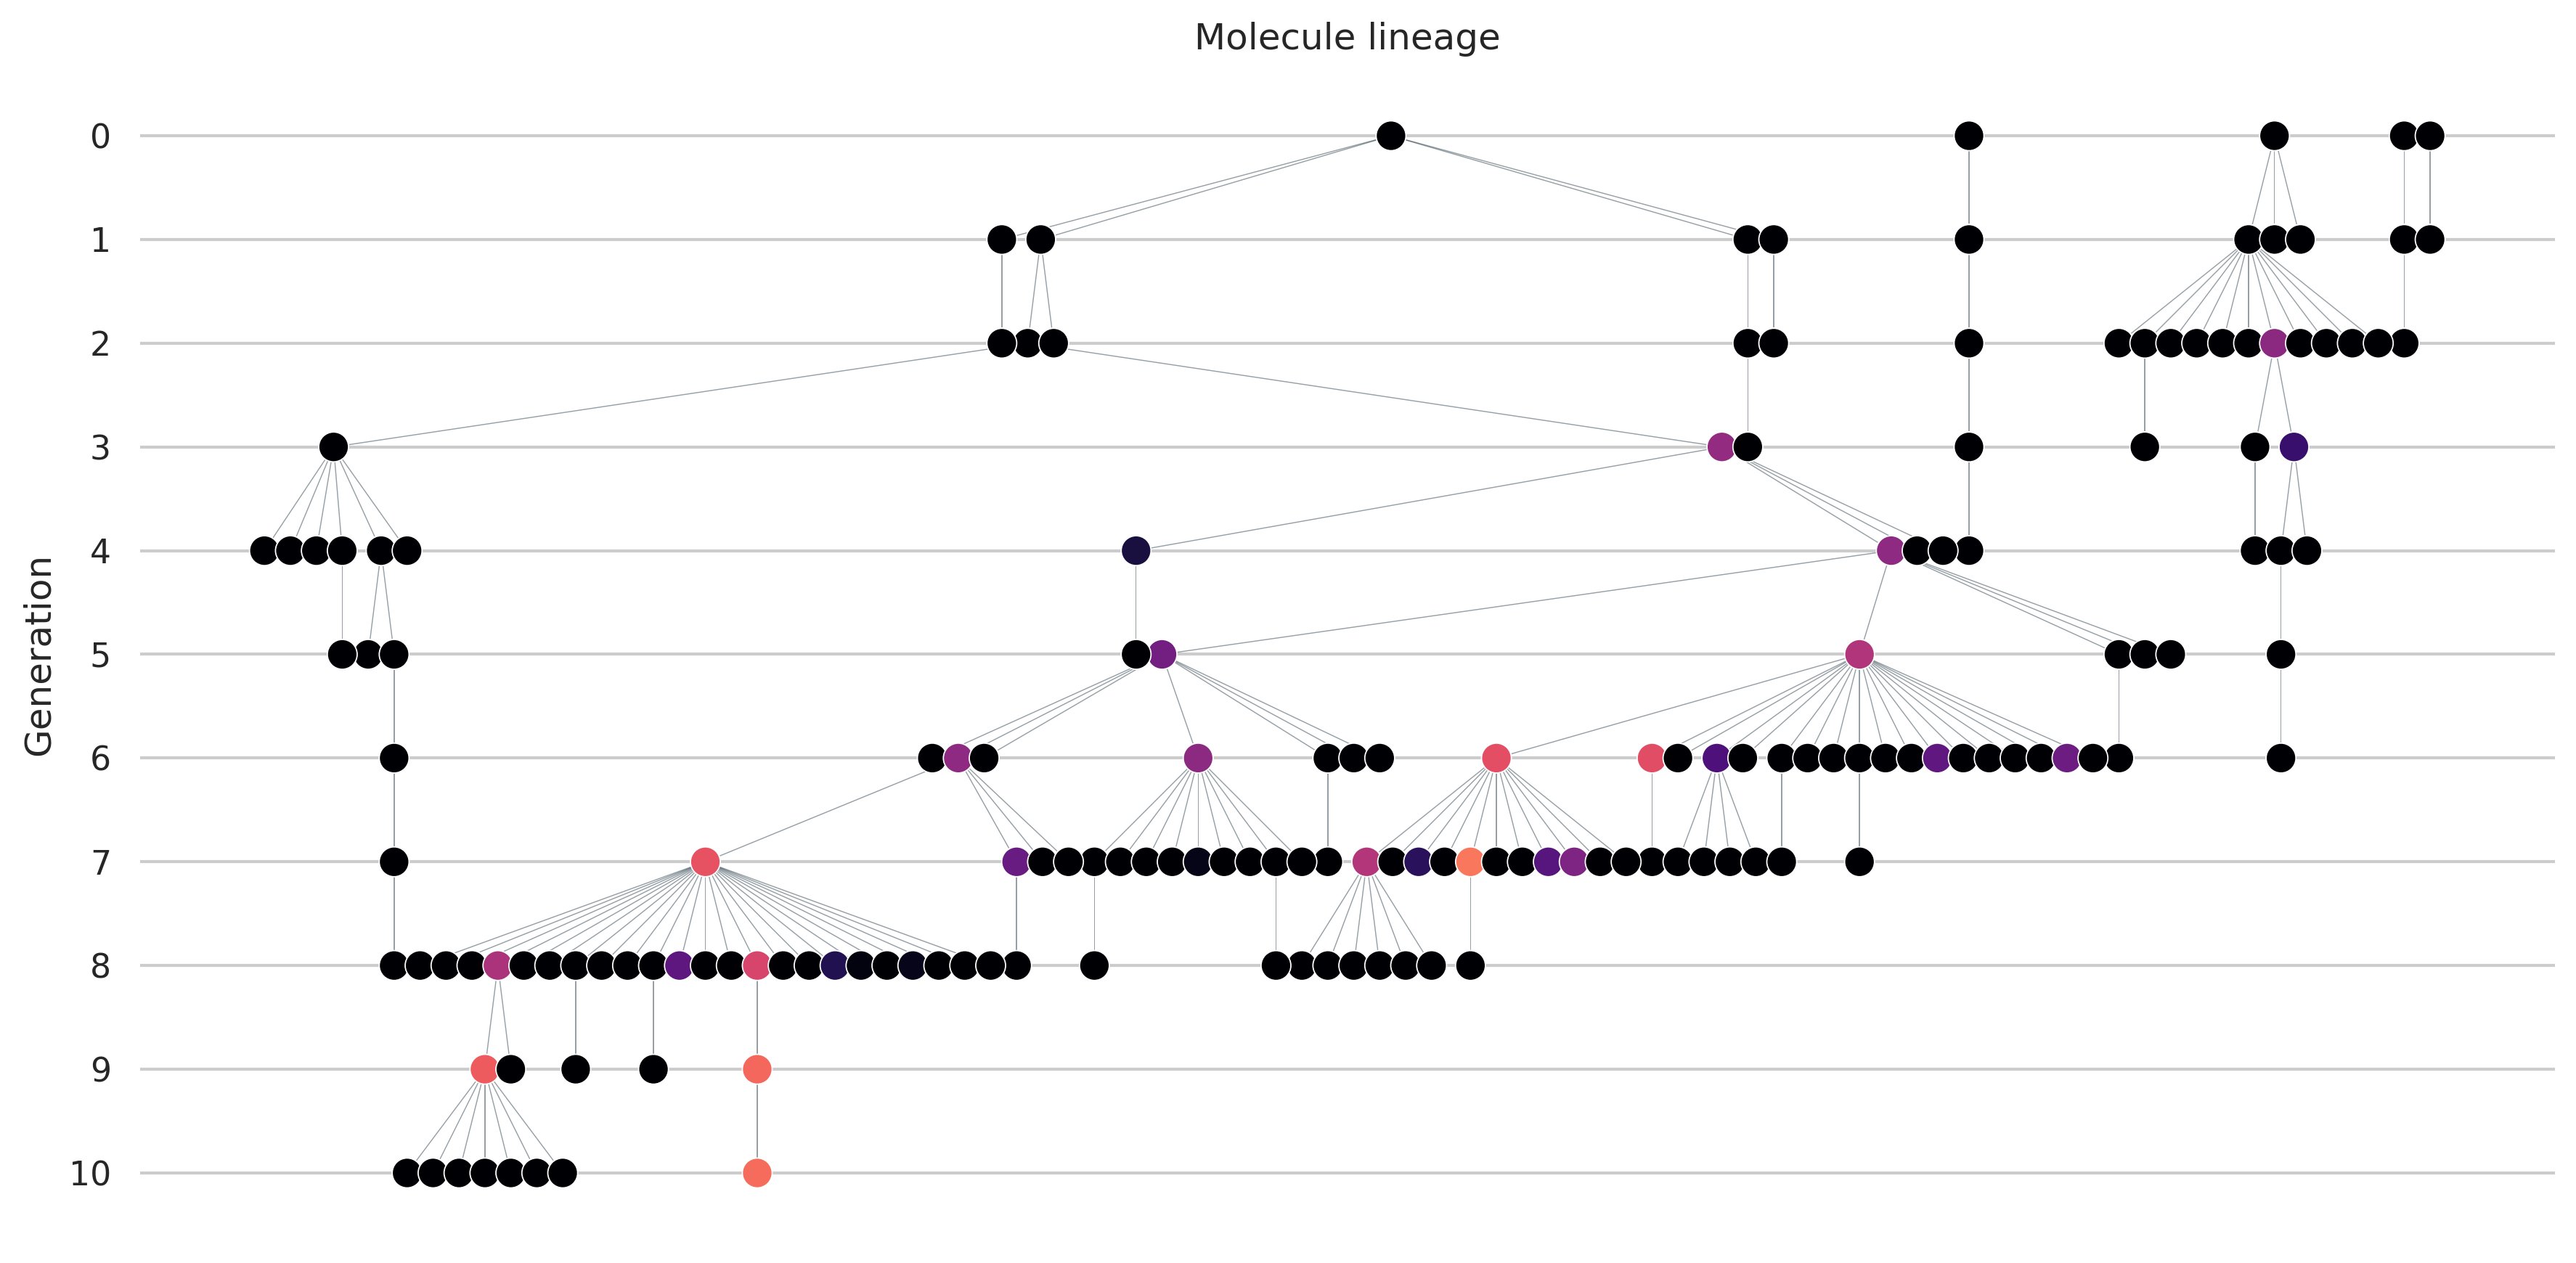

In [27]:
from netgraph import Graph

sns.set_style('whitegrid')
coords = g.layout("rt")
x, y = zip(*coords.coords)
x = np.array([x_ / 20 for x_ in x])
y = np.array([y_ / -5 for y_ in y])
vertices = g.get_vertex_dataframe()['name'].tolist()
coord_dict = {i: (x[i], y[i]) for i, _ in enumerate(vertices)}
color_dict = {i: vertex_colors[i] for i, _ in enumerate(vertices)}

fig, ax = plt.subplots(figsize=(15, 7), dpi=300)
Graph(
    g,
    node_layout=coord_dict,
    edge_width=0.20,
    node_color=color_dict,
    node_edge_color='white',
    node_edge_width=0.25,
    ax=ax
)

unique_y_ticks = np.unique(y)
ax.set_yticks(unique_y_ticks)
ax.set_yticklabels(reversed(range(len(unique_y_ticks))))
ax.set_ylabel('Generation')
ax.set_title('Molecule lineage')

plt.show()